# Data Wrangling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
plt.style.use("seaborn")
#!pip install pandas_datareader
import pandas_datareader.data as web
import pandas_datareader as pdr

In [2]:
df=pd.read_csv('Bitstamp_BTCUSD_1h.csv')
df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1615507200,2021-03-12 00:00:00,BTC/USD,57847.92,58098.50,57452.77,57678.73,43.776942,2.524998e+06
1,1615503600,2021-03-11 23:00:00,BTC/USD,57887.47,58155.99,57605.62,57772.09,164.096973,9.480225e+06
2,1615500000,2021-03-11 22:00:00,BTC/USD,57611.24,58050.00,57483.27,57950.09,167.935774,9.731893e+06
3,1615496400,2021-03-11 21:00:00,BTC/USD,57498.35,57935.19,57313.90,57600.37,230.531312,1.327869e+07
4,1615492800,2021-03-11 20:00:00,BTC/USD,56859.03,57628.62,56564.98,57481.03,223.609640,1.285331e+07


### Data Scraping

In [3]:
#eliminando outras colunas para ficar apenas Close
df.drop(['unix', 'symbol', 'high', 'low', 'open', 'Volume BTC', 'Volume USD'], axis=1,inplace=True)
df.head()

,date,close
0,2021-03-12 00:00:00,57678.73
1,2021-03-11 23:00:00,57772.09
2,2021-03-11 22:00:00,57950.09
3,2021-03-11 21:00:00,57600.37
4,2021-03-11 20:00:00,57481.03


In [4]:
df['date'] = pd.to_datetime(df['date'])
df['Date'] = df['date'].dt.date
df.drop(['date'], axis=1,inplace=True)
df=df.set_index('Date')
df.head()

,close
Date,
2021-03-12,57678.73
2021-03-11,57772.09
2021-03-11,57950.09
2021-03-11,57600.37
2021-03-11,57481.03


In [5]:
df.sort_values(by=['Date'], inplace=True, ascending=True)
df.head()

,close
Date,
2018-05-15,8740.99
2018-05-15,8474.99
2018-05-15,8460.00
2018-05-15,8492.28
2018-05-15,8512.10


In [6]:
#salvar um um arquivo CSV
df.to_csv("Bitstamp1h.csv")

In [7]:
df.close.head()

Date
2018-05-15    8740.99
2018-05-15    8474.99
2018-05-15    8460.00
2018-05-15    8492.28
2018-05-15    8512.10
Name: close, dtype: float64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24762 entries, 2018-05-15 to 2021-03-12
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   24762 non-null  float64
dtypes: float64(1)
memory usage: 386.9+ KB


# Simple Moving Average (SMA) Optimizer

In [9]:
class SMABacktester(): # with ptc 
    ''' Class for the vectorized backtesting of SMA-based trading strategies.

    Attributes
    ==========
    symbol: str
        ticker symbol with which to work with
    SMA_S: int
        time window in days for shorter SMA
    SMA_L: int
        time window in days for longer SMA
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    tc: float
        proportional transaction costs per trade
        
        
    Methods
    =======
    get_data:
        retrieves and prepares the data
        
    set_parameters:
        sets one or two new SMA parameters
        
    test_strategy:
        runs the backtest for the SMA-based strategy
        
    plot_results:
        plots the performance of the strategy compared to buy and hold
        
    update_and_run:
        updates SMA parameters and returns the negative absolute performance (for minimization algorithm)
        
    optimize_parameters:
        implements a brute force optimization for the two SMA parameters
    '''
    
    def __init__(self, symbol, SMA_S, SMA_L, start, end, tc):
        self.symbol = symbol
        self.SMA_S = SMA_S
        self.SMA_L = SMA_L
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None 
        self.get_data()
        
    def __repr__(self):
        return "SMABacktester(symbol = {}, SMA_S = {}, SMA_L = {}, start = {}, end = {})".format(self.symbol, self.SMA_S, self.SMA_L, self.start, self.end)
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv("Bitstamp1h.csv", parse_dates = ["Date"], index_col = "Date")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        raw["SMA_S"] = raw["price"].rolling(self.SMA_S).mean()
        raw["SMA_L"] = raw["price"].rolling(self.SMA_L).mean()
        self.data = raw
        
    def set_parameters(self, SMA_S = None, SMA_L = None):
        ''' Updates SMA parameters and resp. time series.
        '''
        if SMA_S is not None:
            self.SMA_S = SMA_S
            self.data["SMA_S"] = self.data["price"].rolling(self.SMA_S).mean()
        if SMA_L is not None:
            self.SMA_L = SMA_L
            self.data["SMA_L"] = self.data["price"].rolling(self.SMA_L).mean()
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data["SMA_S"] > data["SMA_L"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        trades=data.trades.value_counts()
        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        return round(perf, 6), round(outperf, 6), trades
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | SMA_S = {} | SMA_L = {} | TC = {}".format(self.symbol, self.SMA_S, self.SMA_L, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self, SMA):
        ''' Updates SMA parameters and returns the negative absolute performance (for minimization algorithm).

        Parameters
        ==========
        SMA: tuple
            SMA parameter tuple
        '''
        self.set_parameters(int(SMA[0]), int(SMA[1]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, SMA1_range, SMA2_range):
        ''' Finds global maximum given the SMA parameter ranges.

        Parameters
        ==========
        SMA1_range, SMA2_range: tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, (SMA1_range, SMA2_range), finish=None)
        return opt, -self.update_and_run(opt)

In [10]:
#recent history...MAs are short, no hystorical data
tester_S = SMABacktester("close", 50, 100, "2019-01-01", "2021-03-07", tc=0.001)
tester_S.optimize_parameters((9, 50, 1), (50, 200, 1))

(array([35., 52.]), 423.86176)

In [11]:
tester_S.results

,price,returns,SMA_S,SMA_L,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,
2019-01-03,3778.40,-0.005306,3801.070571,3766.522308,1,-0.005306,0.0,0.994708,0.994708
2019-01-03,3782.09,0.000976,3803.655143,3767.805385,1,0.000976,0.0,0.995680,0.995680
2019-01-03,3781.65,-0.000116,3805.986571,3769.037308,1,-0.000116,0.0,0.995564,0.995564
2019-01-03,3773.39,-0.002187,3807.652286,3769.889808,1,-0.002187,0.0,0.993389,0.993389
2019-01-03,3841.46,0.017879,3811.784000,3772.675962,1,0.017879,0.0,1.011310,1.011310
...,...,...,...,...,...,...,...,...,...
2021-03-07,49483.78,-0.024629,49435.112286,48884.611731,1,-0.024629,0.0,13.027190,424.848763
2021-03-07,50058.25,0.011542,49513.905714,48949.305577,1,0.011542,0.0,13.178426,429.780942
2021-03-07,50400.00,0.006804,49601.464286,49012.007115,1,0.006804,0.0,13.268395,432.715076


In [12]:
tester_S.test_strategy()
#few trades because there is no hystorical data.
#hystorical data is quality!!!

(423.86176,
 410.864835,
 0.0    18533
 2.0      542
 Name: trades, dtype: int64)

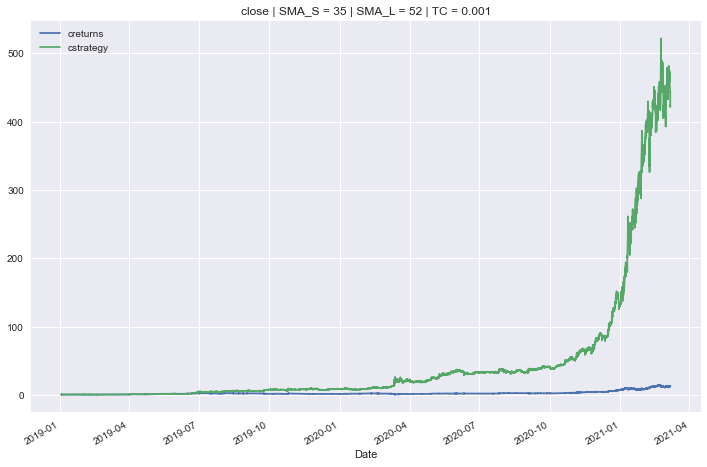

In [13]:
tester_S.plot_results()

# Exponential Moving Average (EMA) Optimizer

In [14]:
class EMABacktester(): 
    ''' Class for the vectorized backtesting of EMA-based trading strategies.

    Attributes
    ==========
    symbol: str
        ticker symbol with which to work with
    EMA_S: int
        time window in days for shorter EMA
    EMA_L: int
        time window in days for longer EMA
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    tc: float
        proportional transaction costs per trade
        
        
    Methods
    =======
    get_data:
        retrieves and prepares the data
        
    set_parameters:
        sets one or two new EMA parameters
        
    test_strategy:
        runs the backtest for the EMA-based strategy
        
    plot_results:
        plots the performance of the strategy compared to buy and hold
        
    update_and_run:
        updates EMA parameters and returns the negative absolute performance (for minimization algorithm)
        
    optimize_parameters:
        implements a brute force optimization for the two EMA parameters
    '''
    
    def __init__(self, symbol, EMA_S, EMA_L, start, end, tc):
        self.symbol = symbol
        self.EMA_S = EMA_S
        self.EMA_L = EMA_L
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None 
        self.get_data()
        
    def __repr__(self):
        return "EMABacktester(symbol = {}, EMA_S = {}, EMA_L = {}, start = {}, end = {})".format(self.symbol, self.EMA_S, self.EMA_L, self.start, self.end)
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv("Bitstamp1h.csv", parse_dates = ["Date"], index_col = "Date")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        raw["EMA_S"] = raw["price"].ewm(span = self.EMA_S, min_periods = self.EMA_S).mean() 
        raw["EMA_L"] = raw["price"].ewm(span = self.EMA_L, min_periods = self.EMA_L).mean() 
        self.data = raw
        
    def set_parameters(self, EMA_S = None, EMA_L = None):
        ''' Updates EMA parameters and resp. time series.
        '''
        if EMA_S is not None:
            self.EMA_S = EMA_S
            self.data["EMA_S"] = self.data["price"].ewm(span = self.EMA_S, min_periods = self.EMA_S).mean() 
        if EMA_L is not None:
            self.EMA_L = EMA_L
            self.data["EMA_L"] = self.data["price"].ewm(span = self.EMA_L, min_periods = self.EMA_L).mean()
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data["EMA_S"] > data["EMA_L"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        trades=data.trades.value_counts()
        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        return round(perf, 6), round(outperf, 6), trades
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | EMA_S = {} | EMA_L = {} | TC = {}".format(self.symbol, self.EMA_S, self.EMA_L, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self, EMA):
        ''' Updates EMA parameters and returns the negative absolute performance (for minimization algorithm).

        Parameters
        ==========
        EMA: tuple
            EMA parameter tuple
        '''
        self.set_parameters(int(EMA[0]), int(EMA[1]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, EMA1_range, EMA2_range):
        ''' Finds global maximum given the EMA parameter ranges.

        Parameters
        ==========
        EMA1_range, EMA2_range: tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, (EMA1_range, EMA2_range), finish=None)
        return opt, -self.update_and_run(opt)

In [15]:
tester_E = EMABacktester("close", 50, 100, "2019-01-01", "2021-03-07", tc=0.001)
tester_E.optimize_parameters((9, 50, 1), (50, 200, 1))

(array([ 49., 141.]), 0.880011)

In [16]:
tester_E.results

,price,returns,EMA_S,EMA_L,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,
2019-01-06,3793.40,0.002193,3846.541355,3828.928832,1,0.002193,0.0,1.002195,1.002195
2019-01-06,3797.10,0.000975,3844.557917,3828.412635,1,0.000975,0.0,1.003173,1.003173
2019-01-06,3803.26,0.001621,3842.901363,3828.005581,1,0.001621,0.0,1.004800,1.004800
2019-01-07,4005.45,0.051797,3849.420829,3830.871215,1,0.051797,0.0,1.058218,1.058218
2019-01-07,3994.57,-0.002720,3855.241813,3833.509417,1,-0.002720,0.0,1.055343,1.055343
...,...,...,...,...,...,...,...,...,...
2021-03-07,49483.78,-0.024629,49365.324209,48922.787531,1,-0.024629,0.0,13.073343,0.882060
2021-03-07,50058.25,0.011542,49393.041241,48938.779961,1,0.011542,0.0,13.225115,0.892300
2021-03-07,50400.00,0.006804,49433.319591,48959.360525,1,0.006804,0.0,13.315403,0.898392


In [17]:
tester_E.test_strategy()

(0.880011,
 -12.162961,
 0.0    18866
 2.0      120
 Name: trades, dtype: int64)

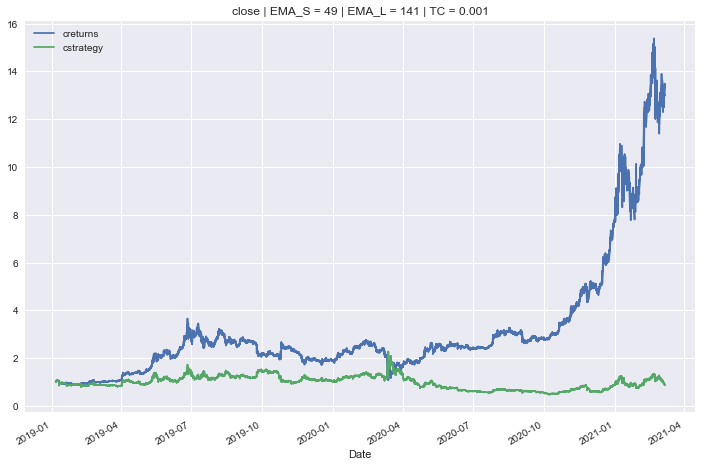

In [18]:
tester_E.plot_results()

# SMA x EMA Optimizer

In [19]:
class SMAEMABacktester(): 
    ''' Class for the vectorized backtesting of SMA/EMA-based trading strategies.

    Attributes
    ==========
    symbol: str
        ticker symbol with which to work with
    SMA: int
        time window in days for SMA
    EMA: int
        time window in days for EMA
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    tc: float
        proportional transaction costs per trade
        
        
    Methods
    =======
    get_data:
        retrieves and prepares the data
        
    set_parameters:
        sets one or two new SMA/EMA parameters
        
    test_strategy:
        runs the backtest for the SMA/EMA-based strategy
        
    plot_results:
        plots the performance of the strategy compared to buy and hold
        
    update_and_run:
        updates EMA parameters and returns the negative absolute performance (for minimization algorithm)
        
    optimize_parameters:
        implements a brute force optimization for the two SAM/EMA parameters
    '''
    
    def __init__(self, symbol, SMA, EMA, start, end, tc):
        self.symbol = symbol
        self.SMA = SMA
        self.EMA = EMA
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None 
        self.get_data()
        
    def __repr__(self):
        return "SMAEMABacktester(symbol = {}, SMA = {}, EMA = {}, start = {}, end = {})".format(self.symbol, self.SMA, self.EMA, self.start, self.end)
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv("Bitstamp1h.csv", parse_dates = ["Date"], index_col = "Date")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        raw["SMA"] = raw["price"].rolling(self.SMA).mean() 
        raw["EMA"] = raw["price"].ewm(span = self.EMA, min_periods = self.EMA).mean() 
        self.data = raw
        
    def set_parameters(self, SMA = None, EMA = None):
        ''' Updates SMA/EMA parameters and resp. time series.
        '''
        if SMA is not None:
            self.SMA = SMA
            self.data["SMA"] = self.data["price"].rolling(self.SMA).mean() 
        if EMA is not None:
            self.EMA = EMA
            self.data["EMA"] = self.data["price"].ewm(span = self.EMA, min_periods = self.EMA).mean()
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data["EMA"] > data["SMA"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        trades=data.trades.value_counts()
        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        return round(perf, 6), round(outperf, 6), trades
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | SMA = {} | EMA = {} | TC = {}".format(self.symbol, self.SMA, self.EMA, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self, SMAEMA):
        ''' Updates SMA/EMA parameters and returns the negative absolute performance (for minimization algorithm).

        Parameters
        ==========
        SMAEMA: tuple
            SMA/EMA parameter tuple
        '''
        self.set_parameters(int(SMAEMA[0]), int(SMAEMA[1]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, SMA_range, EMA_range):
        ''' Finds global maximum given the SMA/EMA parameter ranges.

        Parameters
        ==========
        SMA_range, EMA_range: tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, (SMA_range, EMA_range), finish=None)
        return opt, -self.update_and_run(opt)

In [20]:
tester_SE = SMAEMABacktester("close", 20, 20, "2019-01-01", "2021-03-07", tc=0.001)
tester_SE.optimize_parameters((9, 100, 1), (9, 100, 1))

(array([ 9., 29.]), 3118216527.15556)

In [21]:
tester_SE.results

,price,returns,SMA,EMA,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,
2019-01-02,3849.88,-0.007376,3796.033333,3756.009001,-1,0.007376,0.0,0.992652,1.007403e+00
2019-01-02,3889.29,0.010185,3817.415556,3766.080850,-1,-0.010185,0.0,1.002813,9.971949e-01
2019-01-02,3888.16,-0.000291,3837.685556,3775.224794,-1,0.000291,0.0,1.002522,9.974847e-01
2019-01-02,3885.87,-0.000589,3859.453333,3783.444625,-1,0.000589,0.0,1.001931,9.980725e-01
2019-01-02,3850.00,-0.009274,3861.836667,3788.351615,-1,0.009274,0.0,0.992683,1.007371e+00
...,...,...,...,...,...,...,...,...,...
2021-03-07,49483.78,-0.024629,49797.342222,49657.497331,-1,0.024629,0.0,12.758879,3.110972e+09
2021-03-07,50058.25,0.011542,49759.610000,49684.214176,-1,-0.011542,0.0,12.907000,3.075271e+09
2021-03-07,50400.00,0.006804,49736.904444,49731.933231,-1,-0.006804,0.0,12.995117,3.054418e+09


In [22]:
tester_SE.test_strategy()

(3118216527.15556,
 3118216514.426322,
 0.0    18008
 2.0     1090
 Name: trades, dtype: int64)

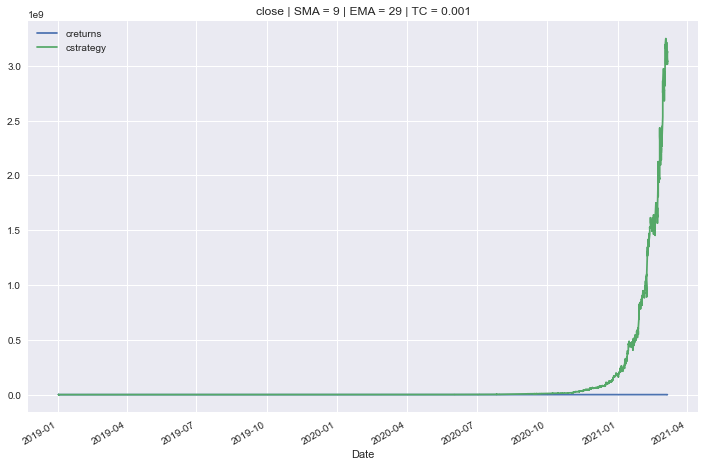

In [23]:
tester_SE.plot_results()